<a href="https://colab.research.google.com/github/ccoyso/Tapia/blob/main/CSDP_PyTorch_Web_ES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Creado archivo 'nodes.csv' de ejemplo.
Creado archivo 'population.csv' de ejemplo.
Creado archivo 'params.csv' de ejemplo.
Nodos cargados desde nodes.csv
Pesos de población cargados desde population.csv
Parámetros (ej: Flujo EV Total=100.0) cargados desde params.csv

Iniciando entrenamiento con 5 nodos...
--- Iniciando Bucle de Entrenamiento RL ---
Ep 1/200: Nueva mejor solución! Costo: 24409320.00, Recompensa: -24409320.00, Loss: 0.00e+00
Ep 2/200: Nueva mejor solución! Costo: 14028900.00, Recompensa: -14028900.00, Loss: 0.00e+00
Ep 3/200: Nueva mejor solución! Costo: 12717610.00, Recompensa: -12717610.00, Loss: 0.00e+00
Ep 5/200: Nueva mejor solución! Costo: 11980770.00, Recompensa: -11980770.00, Loss: 0.00e+00
Ep 7/200: Nueva mejor solución! Costo: 11494710.00, Recompensa: -11494710.00, Loss: 0.00e+00
Ep 8/200: Nueva mejor solución! Costo: 10654920.00, Recompensa: -10654920.00, Loss: 0.00e+00
Ep 13/200: Nueva mejor solución! Costo: 0.00, Recompensa: -0.00, Loss: 0.00e+00
Ep 20/200: 

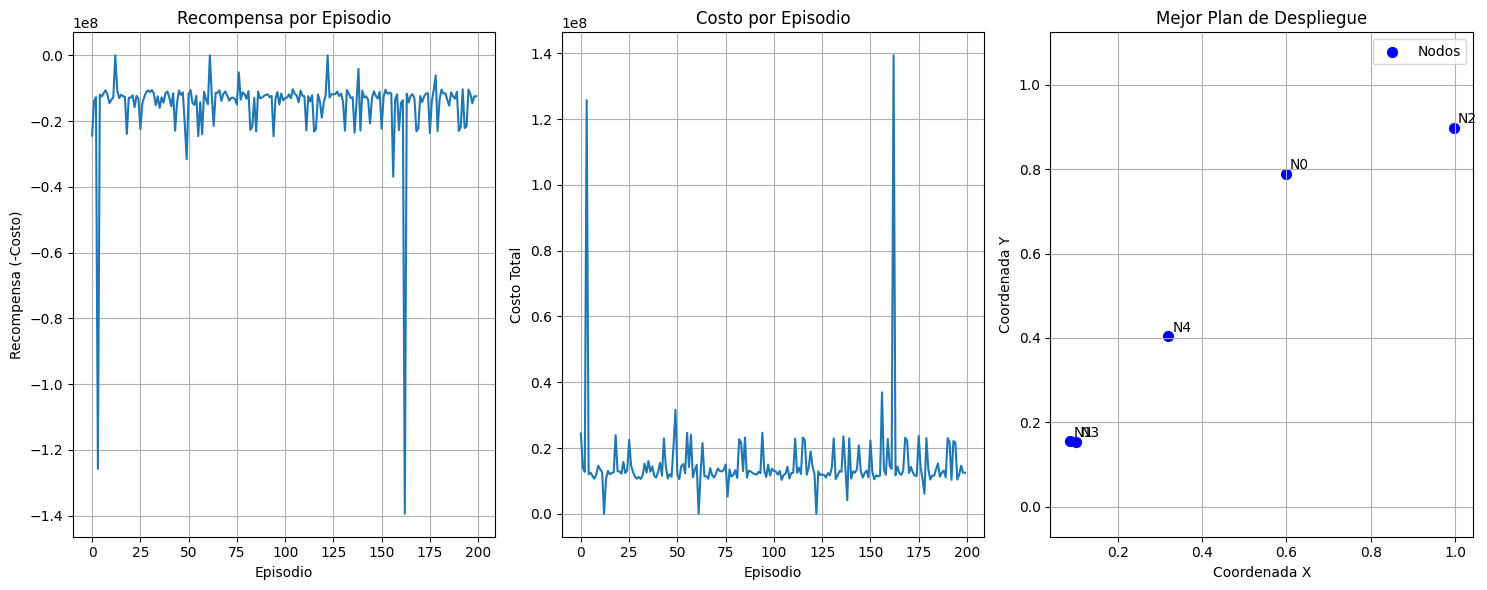

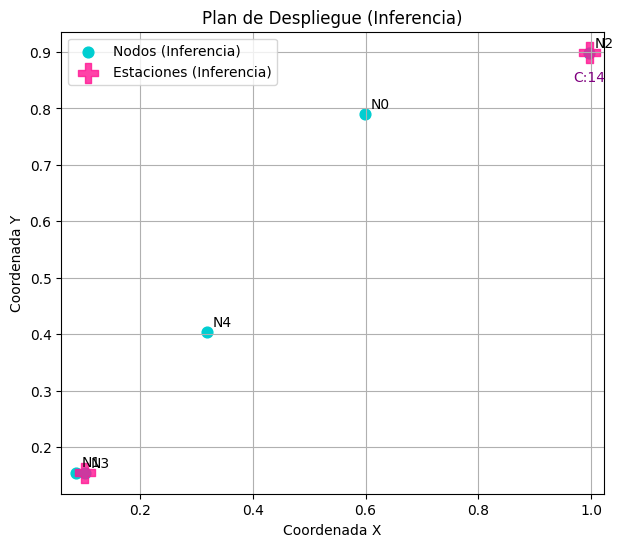

In [1]:
# Importar bibliotecas necesarias
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import os

# --- Imports de PyTorch ---
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Bernoulli # Para selección binaria de estaciones

# --- Parámetros de Configuración (Simplificados, inspirados en Secciones 4.1 & 4.2 del paper) ---

# Parámetros que podrían cargarse desde CSV o configuración web
DEFAULT_NUM_NODES = 5  # Número de nodos en la Red de Transporte (como el ejemplo ilustrativo)
DEFAULT_POPULATION_WEIGHTS = np.array([0.16, 0.25, 0.14, 0.17, 0.28]) # Pesos de población ejemplo
DEFAULT_NODE_COORDS = np.random.rand(DEFAULT_NUM_NODES, 2) # Coordenadas aleatorias si no se carga CSV

# Parámetros de EV y Estaciones de Carga
TOTAL_EV_TRAFFIC_FLOW = 100  # Ejemplo: F_total
AVG_SERVICE_RATE_PER_CHARGER = 2.6  # mu (cargadores por hora)
MAX_CHARGERS_PER_STATION = 25 # n_max
MAX_EXPECTED_WAITING_TIME = 10 / 60  # W_max en horas (10 minutos)

# Parámetros de Costo (Simplificados)
COST_STATION_CONSTRUCTION = 163000 # c_a
COST_PER_CHARGER_INSTALLATION = 31640 # c_b
# Costos PDN simplificados - en un modelo real, dependen del flujo de potencia, longitud de línea, capacidad
COST_PER_UNIT_DISTRIBUTION_LINE = 120 # c_l^u (ejemplo, muy simplificado)
COST_SUBSTATION_EXPANSION_PER_KVA = 788 # c_p^u (ejemplo)
RATED_CHARGER_POWER_KW = 62.5 # p

# Parámetros RL
DISCOUNT_FACTOR_GAMMA = 0.99 # Factor de descuento para recompensas futuras
LEARNING_RATE = 0.001 # Tasa de aprendizaje para el optimizador del agente

# --- Funciones Auxiliares ---

def load_data_from_csv(node_file='nodes.csv', pop_file='population.csv', params_file='params.csv'):
    """
    Carga datos de nodos (coordenadas), población y parámetros desde archivos CSV.
    Retorna los datos cargados o valores por defecto si los archivos no existen.
    """
    num_nodes = DEFAULT_NUM_NODES
    node_coords = DEFAULT_NODE_COORDS
    population_weights = DEFAULT_POPULATION_WEIGHTS
    total_ev_flow = TOTAL_EV_TRAFFIC_FLOW

    # Cargar coordenadas de nodos
    if os.path.exists(node_file):
        try:
            df_nodes = pd.read_csv(node_file)
            node_coords = df_nodes[['x', 'y']].values
            num_nodes = len(node_coords) # Actualizar el número de nodos basado en el archivo
            print(f"Nodos cargados desde {node_file}")
        except Exception as e:
            print(f"Error cargando {node_file}: {e}. Usando valores por defecto para nodos.")
            # Si falla la carga de nodos, es mejor usar los defaults completos para consistencia
            num_nodes = DEFAULT_NUM_NODES
            node_coords = DEFAULT_NODE_COORDS

    # Cargar pesos de población
    if os.path.exists(pop_file):
        try:
            df_pop = pd.read_csv(pop_file)
            # Asegurarse que los pesos de población coincidan con el número de nodos
            if len(df_pop) == num_nodes:
                population_weights = df_pop['weight'].values
                print(f"Pesos de población cargados desde {pop_file}")
            else:
                print(f"Advertencia: El número de pesos en {pop_file} ({len(df_pop)}) no coincide con el número de nodos ({num_nodes}).")
                if num_nodes == DEFAULT_NUM_NODES: # Si num_nodes no cambió, usar default weights
                    population_weights = DEFAULT_POPULATION_WEIGHTS
                    print("Usando pesos de población por defecto.")
                else: # Si num_nodes cambió, generar nuevos pesos aleatorios consistentes
                    population_weights = np.random.rand(num_nodes)
                    population_weights = population_weights / np.sum(population_weights) # Normalizar
                    print(f"Generando pesos de población aleatorios para {num_nodes} nodos.")
        except Exception as e:
            print(f"Error cargando {pop_file}: {e}. Usando pesos de población por defecto/aleatorios.")
            if num_nodes == DEFAULT_NUM_NODES:
                population_weights = DEFAULT_POPULATION_WEIGHTS
            else:
                population_weights = np.random.rand(num_nodes)
                population_weights = population_weights / np.sum(population_weights)

    # Cargar otros parámetros, como el flujo total de EVs
    if os.path.exists(params_file):
        try:
            df_params = pd.read_csv(params_file)
            if 'TOTAL_EV_TRAFFIC_FLOW' in df_params['parameter'].values:
                total_ev_flow = float(df_params[df_params['parameter'] == 'TOTAL_EV_TRAFFIC_FLOW']['value'].iloc[0])
                print(f"Parámetros (ej: Flujo EV Total={total_ev_flow}) cargados desde {params_file}")
        except Exception as e:
            print(f"Error cargando {params_file}: {e}. Usando flujo EV por defecto.")
            total_ev_flow = TOTAL_EV_TRAFFIC_FLOW


    # Asegurar que los pesos de población por defecto coincidan con num_nodes si este cambió
    if len(population_weights) != num_nodes:
        print(f"Ajustando pesos de población para {num_nodes} nodos.")
        if num_nodes == DEFAULT_NUM_NODES and np.array_equal(node_coords, DEFAULT_NODE_COORDS):
             population_weights = DEFAULT_POPULATION_WEIGHTS
        else:
            population_weights = np.random.rand(num_nodes)
            population_weights = population_weights / np.sum(population_weights) # Normalizar

    return num_nodes, node_coords, population_weights, total_ev_flow


def calculate_distance_matrix(coords):
    """Calcula la matriz de distancias Euclidianas entre nodos."""
    dist_matrix = np.zeros((len(coords), len(coords)))
    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            # Prevenir error si las coordenadas son idénticas o no válidas
            try:
                dist = np.linalg.norm(np.array(coords[i]) - np.array(coords[j]))
                dist_matrix[i, j] = dist_matrix[j, i] = dist
            except Exception as e:
                print(f"Error calculando distancia entre nodo {i} y {j}: {e}. Usando distancia infinita.")
                dist_matrix[i, j] = dist_matrix[j, i] = float('inf')
    return dist_matrix

def estimate_traffic_volume_gravity(pop_weights, dist_matrix):
    """
    Estima el volumen de tráfico entre nodos usando el modelo de gravedad.
    f_ij = k * (w_i * w_j) / d_ij^alpha (Aquí, usando d_ij como en Eq 1, alpha=1, k=1.5)
    """
    num_nodes = len(pop_weights)
    traffic_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j or dist_matrix[i, j] == 0 or math.isinf(dist_matrix[i,j]): # Evitar división por cero o inf
                continue
            # El paper usa 1.5 * w_i * w_j / d_ij
            traffic_matrix[i, j] = 1.5 * pop_weights[i] * pop_weights[j] / dist_matrix[i, j]
    return traffic_matrix

def get_aggregate_arrival_rate(node_idx, station_locations_indices, total_ev_flow, traffic_volume_matrix, dist_matrix):
    """
    Calcula la tasa de llegada agregada de EVs a una estación de carga específica.
    Simplificado: Asume que los EVs de cualquier nodo 'j' van a la estación 'i' *más cercana*.
    La Eq 2 del paper es más compleja.
    Esto es una simplificación para ilustración.
    """
    if not station_locations_indices: # si la lista está vacía
        return 0.0

    arrival_rate_at_station = 0.0
    num_all_nodes = len(traffic_volume_matrix) # Número total de nodos en la red

    # Para cada nodo en la red (como origen de viaje)
    for origin_node_idx in range(num_all_nodes):
        min_dist_to_station = float('inf')
        target_station_idx = -1

        # Encontrar la estación activa más cercana a este origin_node_idx
        for stat_loc_idx in station_locations_indices:
            # Asegurarse que los índices están dentro de los límites de dist_matrix
            if origin_node_idx < dist_matrix.shape[0] and stat_loc_idx < dist_matrix.shape[1]:
                dist = dist_matrix[origin_node_idx, stat_loc_idx]
                if dist < min_dist_to_station:
                    min_dist_to_station = dist
                    target_station_idx = stat_loc_idx
            else:
                # Esto no debería ocurrir si los datos están bien formados
                print(f"Advertencia: Índice fuera de rango en get_aggregate_arrival_rate. origin:{origin_node_idx}, station:{stat_loc_idx}, dist_matrix_shape:{dist_matrix.shape}")
                continue


        # Si la estación actual (node_idx, que es una de las station_locations_indices)
        # es la estación más cercana para origin_node_idx
        if target_station_idx == node_idx:
            # Suma del tráfico originado desde origin_node_idx a todos los otros nodos
            total_flow_from_origin = np.sum(traffic_volume_matrix[origin_node_idx, :])
            sum_total_traffic_volume = np.sum(traffic_volume_matrix)

            if sum_total_traffic_volume > 0: # Evitar división por cero
                # Proporción del flujo total de EV que se origina en origin_node_idx y va a esta estación
                arrival_rate_at_station += total_ev_flow * (total_flow_from_origin / sum_total_traffic_volume)
    return arrival_rate_at_station


def erlang_c_formula(arrival_rate, n_chargers, service_rate_per_charger):
    """
    Calcula la fórmula C de Erlang C(rho), probabilidad de espera.
    A (intensidad de tráfico ofrecida) = lambda / mu_per_charger
    """
    if n_chargers <= 0: return 1.0 # Máxima probabilidad de espera si no hay cargadores o es inválido
    if service_rate_per_charger <= 0: return 1.0 # Tasa de servicio inválida

    lambda_val = float(arrival_rate)
    N = float(n_chargers)
    mu_individual = float(service_rate_per_charger)

    A = lambda_val / mu_individual # Intensidad de tráfico ofrecida

    # El sistema es estable si N > A (o n * mu > lambda)
    if N <= A:
        return 1.0 # Cola inestable, probabilidad de espera es 1

    # Numerador de la fórmula C de Erlang
    try:
        term_A_N_N_fact = (A**N) / math.factorial(int(N))
    except OverflowError: # A^N puede ser muy grande
        return 1.0
    term_N_N_minus_A = N / (N - A)
    numerator_C = term_A_N_N_fact * term_N_N_minus_A

    # Denominador de la fórmula C de Erlang
    sum_A_i_i_fact = 0.0
    for i in range(int(N)): # Suma de k=0 a N-1
        try:
            sum_A_i_i_fact += (A**i) / math.factorial(i)
        except OverflowError: # Si A^i es muy grande, la suma será dominada por términos posteriores o el numerador
                              # lo que llevaría a C_val -> 1 o un valor muy alto.
                              # Para simplificar, si un término intermedio desborda, asumimos alta congestión.
            if A > 1 : # Si la intensidad por servidor es alta, es probable que la cola sea inestable
                return 1.0


    denominator_C = sum_A_i_i_fact + numerator_C # El numerator_C es el último término de la suma del denominador

    if denominator_C == 0: return 1.0 # Evitar división por cero

    C_val = numerator_C / denominator_C
    return C_val


def expected_waiting_time(arrival_rate, num_chargers, service_rate_per_charger):
    """
    Calcula el tiempo de espera esperado E(W) usando el modelo de cola M/M/n.
    """
    if num_chargers <= 0:
        return float('inf') # Espera infinita si no hay cargadores
    if service_rate_per_charger <= 0:
        return float('inf')


    mu_total_system = float(num_chargers * service_rate_per_charger)
    lambda_val = float(arrival_rate)

    if mu_total_system <= lambda_val: # Intensidad de tráfico >= 1, cola inestable
        return float('inf')

    C_rho_val = erlang_c_formula(lambda_val, num_chargers, service_rate_per_charger)

    # E(W) = C(rho) / (n*mu - lambda)
    wait_time = C_rho_val / (mu_total_system - lambda_val)
    return wait_time


# --- Clase Entorno (CSDP Simplificado) ---
class CSDPEnv:
    def __init__(self, num_nodes, node_coords, pop_weights, total_ev_flow):
        self.num_nodes = int(num_nodes)
        self.node_coords = np.array(node_coords)
        self.pop_weights = np.array(pop_weights)
        self.dist_matrix = calculate_distance_matrix(self.node_coords)
        self.traffic_volume_matrix = estimate_traffic_volume_gravity(self.pop_weights, self.dist_matrix)
        self.total_ev_flow = float(total_ev_flow)
        self.current_solution = None # Almacenará (station_locations, num_chargers)

    def calculate_costs_and_constraints(self, station_locations_binary, num_chargers_at_locs):
        """
        Calcula el costo total de inversión y verifica restricciones.
        """
        station_locations_binary = np.array(station_locations_binary, dtype=int)
        num_chargers_at_locs = np.array(num_chargers_at_locs, dtype=int)

        cost_tn = 0.0
        cost_tn += np.sum(station_locations_binary * COST_STATION_CONSTRUCTION)
        active_station_indices = np.where(station_locations_binary == 1)[0]

        for i in active_station_indices:
            cost_tn += COST_PER_CHARGER_INSTALLATION * num_chargers_at_locs[i]

        cost_pdn_lines = 0.0
        cost_pdn_substation_expansion = 0.0
        constraint_penalty = 0.0

        actual_station_indices_list = list(active_station_indices)

        for i in active_station_indices:
            if num_chargers_at_locs[i] > MAX_CHARGERS_PER_STATION:
                constraint_penalty += 1e9 * (num_chargers_at_locs[i] - MAX_CHARGERS_PER_STATION)


            arrival_rate_i = get_aggregate_arrival_rate(i, actual_station_indices_list,
                                                       self.total_ev_flow, self.traffic_volume_matrix,
                                                       self.dist_matrix)

            if num_chargers_at_locs[i] > 0:
                wait_time_i = expected_waiting_time(arrival_rate_i, num_chargers_at_locs[i], AVG_SERVICE_RATE_PER_CHARGER)
                if not math.isfinite(wait_time_i) or wait_time_i > MAX_EXPECTED_WAITING_TIME:
                    penalty_factor = (wait_time_i - MAX_EXPECTED_WAITING_TIME) if math.isfinite(wait_time_i) else 1.0
                    constraint_penalty += penalty_factor * 1e7 + 1e5 # Penalización base + proporcional
            elif arrival_rate_i > 0 and num_chargers_at_locs[i] == 0 :
                 constraint_penalty += 1e9 # Demanda no satisfecha

            power_station_i_kw = num_chargers_at_locs[i] * RATED_CHARGER_POWER_KW
            L_i_assumed = 1.0 # km
            cost_pdn_lines += power_station_i_kw * L_i_assumed * COST_PER_UNIT_DISTRIBUTION_LINE

            surplus_capacity_kva_assumed = 400.0 # KVA
            power_station_i_kva = power_station_i_kw
            expansion_needed_kva = max(0.0, power_station_i_kva - surplus_capacity_kva_assumed)
            cost_pdn_substation_expansion += expansion_needed_kva * COST_SUBSTATION_EXPANSION_PER_KVA

        total_investment_cost = cost_tn + cost_pdn_lines + cost_pdn_substation_expansion
        final_cost = total_investment_cost + constraint_penalty
        return final_cost, cost_tn, cost_pdn_lines, cost_pdn_substation_expansion, constraint_penalty

    def step(self, action_locations_binary, action_num_chargers):
        """ Evalúa una acción (plan de despliegue completo). """
        self.current_solution = (np.array(action_locations_binary), np.array(action_num_chargers))
        cost, c_tn, c_l, c_p, penalty = self.calculate_costs_and_constraints(action_locations_binary, action_num_chargers)
        reward = -cost # Recompensa es el negativo del costo
        next_state = self.current_solution
        done = True # Un episodio termina después de evaluar una solución completa
        return next_state, reward, done, {"cost": cost, "c_tn":c_tn, "c_l":c_l, "c_p":c_p, "penalty": penalty}

    def reset(self):
        """ Reinicia a un estado inicial (ej. sin estaciones). """
        initial_locations = np.zeros(self.num_nodes, dtype=int)
        initial_chargers = np.zeros(self.num_nodes, dtype=int)
        self.current_solution = (initial_locations, initial_chargers)
        return self.current_solution


# --- Agente con PyTorch (Política Simplificada) ---
class PolicyNetwork(nn.Module):
    def __init__(self, num_nodes, hidden_dim=64):
        super(PolicyNetwork, self).__init__()
        # Red neuronal simple para decidir ubicaciones de estaciones.
        # La entrada es un vector de tamaño num_nodes (podría ser un embedding del estado).
        self.fc1 = nn.Linear(num_nodes, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_nodes) # Salida: logits para cada nodo (tener o no estación)

    def forward(self, state_input_features):
        # 'state_input_features' debería ser un tensor que represente el estado actual.
        # Para esta política simple, podría ser un tensor de unos o ceros, o características de nodos.
        x = F.relu(self.fc1(state_input_features))
        logits = self.fc2(x) # Logits para la distribución Bernoulli por cada nodo
        return logits

class RLAgent:
    def __init__(self, num_nodes, learning_rate=LEARNING_RATE):
        self.num_nodes = int(num_nodes)
        self.policy_network = PolicyNetwork(self.num_nodes)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=learning_rate)
        self.saved_log_probs = []
        self.rewards = []

    def choose_action(self, state_features_tensor):
        """ Elige ubicaciones de estaciones y número de cargadores. """
        # El 'state_features_tensor' es la entrada para la red de política.
        # Podría ser tan simple como un tensor de unos si la política no es condicional al estado detallado.
        logits = self.policy_network(state_features_tensor)
        probs = torch.sigmoid(logits)
        dist = Bernoulli(probs) # Distribución Bernoulli para cada nodo
        station_locations_tensor = dist.sample() # Muestra {0,1} para cada nodo

        # Guardar log_prob de la acción tomada (suma de log_probs de Bernoulli)
        # Asegurarse que station_locations_tensor tenga el mismo shape que probs para log_prob
        log_prob = dist.log_prob(station_locations_tensor).sum()
        self.saved_log_probs.append(log_prob)

        station_locations_binary = station_locations_tensor.detach().cpu().numpy().astype(int).flatten() # Aplanar por si acaso

        num_chargers = np.zeros(self.num_nodes, dtype=int)
        active_indices = np.where(station_locations_binary == 1)[0]
        for idx in active_indices:
            # Asignación heurística/aleatoria de cargadores
            num_chargers[idx] = np.random.randint(1, MAX_CHARGERS_PER_STATION + 1)

        return station_locations_binary, num_chargers

    def update_policy(self):
        """ Actualiza la política usando REINFORCE. """
        if not self.saved_log_probs:
            return 0.0 # No hay nada que actualizar

        R = 0.0
        policy_loss_terms = []
        returns = []

        for r_val in self.rewards[::-1]: # Iterar recompensas en reversa
            R = r_val + DISCOUNT_FACTOR_GAMMA * R
            returns.insert(0, R) # Insertar al principio para mantener el orden

        returns_tensor = torch.tensor(returns, dtype=torch.float32)
        # Normalizar los retornos
        if len(returns_tensor) > 1:
            returns_tensor = (returns_tensor - returns_tensor.mean()) / (returns_tensor.std() + 1e-9)
        elif len(returns_tensor) == 1: # Evitar NaN para std de un solo elemento
             returns_tensor = (returns_tensor - returns_tensor.mean())


        for log_prob, R_val in zip(self.saved_log_probs, returns_tensor):
            policy_loss_terms.append(-log_prob * R_val)

        self.optimizer.zero_grad()
        # Verificar si policy_loss_terms está vacío antes de concatenar
        if not policy_loss_terms:
            # print("Advertencia: policy_loss_terms está vacío en update_policy.")
            # Limpiar para el próximo episodio
            self.saved_log_probs = []
            self.rewards = []
            return 0.0

        policy_loss_tensor = torch.stack(policy_loss_terms).sum() # Usar stack si son tensores escalares

        policy_loss_tensor.backward()
        self.optimizer.step()

        loss_value = policy_loss_tensor.item()
        self.saved_log_probs = []
        self.rewards = []
        return loss_value


    def save_model(self, path="policy_agent.pth"):
        torch.save(self.policy_network.state_dict(), path)
        print(f"Modelo del agente guardado en {path}")

    def load_model(self, path="policy_agent.pth"):
        if os.path.exists(path):
            try:
                self.policy_network.load_state_dict(torch.load(path))
                self.policy_network.eval() # Poner en modo evaluación
                print(f"Modelo del agente cargado desde {path}")
            except Exception as e:
                print(f"Error cargando modelo desde {path}: {e}. Usando agente no entrenado.")
        else:
            print(f"No se encontró el modelo en {path}, se usará un agente no entrenado.")


# --- Simulación Principal / Bucle de Entrenamiento ---
def train_agent_main(env, agent, num_episodes=100, plot_dir="plots_results", model_save_name="trained_agent.pth"):
    """ Entrena al agente RL y guarda resultados. """
    os.makedirs(plot_dir, exist_ok=True)

    all_episode_rewards = []
    all_episode_costs = []
    best_solution_overall = None
    best_reward_overall = -float('inf')
    best_cost_overall = float('inf')

    # Crear un tensor de entrada para la red de política.
    # Para esta política simple, puede ser un tensor constante si no depende del estado detallado.
    # O podría ser una representación del estado (ej. ubicaciones actuales si fuera secuencial).
    # Aquí, usaremos un tensor de unos como entrada genérica.
    static_state_input_for_policy = torch.ones(1, env.num_nodes, dtype=torch.float32) # Batch_size=1

    print("--- Iniciando Bucle de Entrenamiento RL ---")
    for episode in range(num_episodes):
        _ = env.reset() # El estado inicial no se usa mucho en esta política simple

        action_locations, action_chargers = agent.choose_action(static_state_input_for_policy)
        _, reward, _, info = env.step(action_locations, action_chargers)

        agent.rewards.append(reward)
        all_episode_rewards.append(reward)
        all_episode_costs.append(info['cost'])

        loss_val = agent.update_policy() # Actualizar política al final del episodio

        if info['cost'] < best_cost_overall : # Guardar la mejor solución basada en el costo mínimo
            best_reward_overall = reward
            best_cost_overall = info['cost']
            best_solution_overall = (action_locations, action_chargers)
            print(f"Ep {episode+1}/{num_episodes}: Nueva mejor solución! Costo: {info['cost']:.2f}, Recompensa: {reward:.2f}, Loss: {loss_val:.2e}")
        elif (episode + 1) % (num_episodes // 10 if num_episodes >=10 else 1) == 0 :
             print(f"Ep {episode+1}/{num_episodes}: Costo: {info['cost']:.2f}, Recompensa: {reward:.2f}, Loss: {loss_val:.2e}")

    print("\n--- Entrenamiento Finalizado ---")
    model_full_path = os.path.join(plot_dir, model_save_name)
    agent.save_model(model_full_path)

    if best_solution_overall:
        print(f"Mejor solución (costo más bajo): {best_cost_overall:,.2f}")
        print(f"  Ubicaciones: {best_solution_overall[0]}")
        print(f"  Cargadores: {best_solution_overall[1]}")

        plt.figure(figsize=(15, 6))
        plt.subplot(1, 3, 1)
        plt.plot(all_episode_rewards)
        plt.title('Recompensa por Episodio')
        plt.xlabel('Episodio'); plt.ylabel('Recompensa (-Costo)')
        plt.grid(True)

        plt.subplot(1, 3, 2)
        plt.plot(all_episode_costs)
        plt.title('Costo por Episodio')
        plt.xlabel('Episodio'); plt.ylabel('Costo Total')
        plt.grid(True)

        plt.subplot(1, 3, 3)
        plt.scatter(env.node_coords[:, 0], env.node_coords[:, 1], c='blue', label='Nodos', s=50)
        active_station_coords = env.node_coords[best_solution_overall[0] == 1]
        num_chargers_at_active = best_solution_overall[1][best_solution_overall[0] == 1]

        if active_station_coords.any():
            # Escalar tamaño de marcador por número de cargadores
            sizes = np.array(num_chargers_at_active) * 10 + 100 # Ajustar escala según sea necesario
            plt.scatter(active_station_coords[:, 0], active_station_coords[:, 1],
                        s=sizes, c='red', marker='s', label='Estaciones', alpha=0.7)
        for i in range(env.num_nodes):
            plt.annotate(f"N{i}", (env.node_coords[i, 0]+0.01, env.node_coords[i, 1]+0.01))
        if active_station_coords.any():
            active_indices = np.where(best_solution_overall[0] == 1)[0]
            for i, idx in enumerate(active_indices):
                 plt.annotate(f"C:{best_solution_overall[1][idx]}", (env.node_coords[idx,0], env.node_coords[idx,1]-0.05), color='darkred', ha='center')
        plt.title('Mejor Plan de Despliegue')
        plt.xlabel('Coordenada X'); plt.ylabel('Coordenada Y')
        plt.legend(); plt.grid(True); plt.axis('equal')

        plt.tight_layout()
        plot_filename = os.path.join(plot_dir, "summary_training_plot.png")
        plt.savefig(plot_filename)
        print(f"Gráfico de resumen guardado en {plot_filename}")
        # plt.show() # Comentar para ejecución no interactiva

        analyze_solution_details(env, best_solution_overall, "Análisis de la Mejor Solución del Entrenamiento")
    else:
        print("No se encontró una solución durante el entrenamiento.")
    return best_solution_overall, best_cost_overall


def analyze_solution_details(env, solution_plan, title="Análisis de Solución"):
    """ Analiza e imprime detalles de un plan de despliegue dado. """
    print(f"\n--- {title} ---")
    if not solution_plan or solution_plan[0] is None or solution_plan[1] is None:
        print("No hay plan de solución válido para analizar.")
        return

    locations_bin, chargers_arr = solution_plan
    final_cost, c_tn, c_lines, c_sub, penalty_val = env.calculate_costs_and_constraints(locations_bin, chargers_arr)
    print(f"Costo Final Total: ${final_cost:,.2f}")
    print(f"  - Inversión TN (Estaciones y Cargadores): ${c_tn:,.2f}")
    print(f"  - Costos Línea PDN (Simplificado): ${c_lines:,.2f}")
    print(f"  - Expansión Subestación PDN (Simplificado): ${c_sub:,.2f}")
    print(f"  - Penalizaciones por Restricciones: ${penalty_val:,.2f}")

    active_station_indices = np.where(np.array(locations_bin) == 1)[0]
    print("\nDetalles de Estaciones Activas:")
    if not active_station_indices.any():
        print("  No hay estaciones activas en este plan.")
        return

    for s_idx in active_station_indices:
        arr_rate = get_aggregate_arrival_rate(s_idx, list(active_station_indices),
                                             env.total_ev_flow, env.traffic_volume_matrix,
                                             env.dist_matrix)
        num_ch = chargers_arr[s_idx]
        if num_ch > 0:
            wait_t_hr = expected_waiting_time(arr_rate, num_ch, AVG_SERVICE_RATE_PER_CHARGER)
            wait_t_min = wait_t_hr * 60.0 if math.isfinite(wait_t_hr) else float('inf')
            print(f"  Estación en Nodo {s_idx}: {num_ch} cargadores, Tasa Llegada: {arr_rate:.2f} EV/hr, Esp. Espera: {wait_t_min:.2f} min")
        else:
            print(f"  Estación en Nodo {s_idx}: 0 cargadores, Tasa Llegada: {arr_rate:.2f} EV/hr")


# --- Funciones para "Integración Web" (Cargar modelo y obtener predicción) ---
def get_web_deployment_plan(env_config_dict, model_path="plots_results/trained_agent.pth"):
    """
    Carga un agente entrenado y genera un plan de despliegue para una configuración dada.
    env_config_dict: un diccionario con 'num_nodes', 'node_coords', 'pop_weights', 'total_ev_flow'.
    Retorna el plan (ubicaciones, cargadores) y detalles del costo.
    """
    try:
        current_env = CSDPEnv(
            num_nodes=int(env_config_dict['num_nodes']),
            node_coords=np.array(env_config_dict['node_coords']),
            pop_weights=np.array(env_config_dict['pop_weights']),
            total_ev_flow=float(env_config_dict['total_ev_flow'])
        )
    except KeyError as e:
        return {"error": f"Falta el parámetro de entorno: {e}"}, None, None
    except Exception as e:
        return {"error": f"Error inicializando el entorno: {e}"}, None, None

    agent = RLAgent(current_env.num_nodes)
    agent.load_model(model_path) # load_model maneja el caso de archivo no encontrado

    # Para inferencia, no necesitamos gradientes y la red debe estar en modo eval
    agent.policy_network.eval()
    with torch.no_grad():
        # La entrada a la política debe coincidir con lo que espera.
        # Si la política es simple, un tensor de unos es suficiente.
        # Si es más compleja, necesitaría características del estado actual.
        static_input_for_policy = torch.ones(1, current_env.num_nodes, dtype=torch.float32)
        # choose_action no debería guardar log_probs si está en modo eval o se limpia después
        locations, chargers = agent.choose_action(static_input_for_policy)

    agent.saved_log_probs = [] # Asegurar limpieza

    # Evaluar el plan generado
    cost_final, ctn, cl, cp, pen = current_env.calculate_costs_and_constraints(locations, chargers)

    plan_details = {
        "locations_binary": locations.tolist(),
        "chargers_per_station": chargers.tolist(),
        "total_cost": cost_final,
        "cost_tn": ctn,
        "cost_pdn_lines": cl,
        "cost_pdn_substation": cp,
        "penalty_constraints": pen,
        "node_coordinates": current_env.node_coords.tolist(), # Para visualización en frontend
        "population_weights": current_env.pop_weights.tolist()
    }
    # También se podrían añadir detalles de tiempo de espera por estación aquí
    return plan_details, locations, chargers, current_env


if __name__ == '__main__':
    # --- Crear archivos CSV de ejemplo si no existen ---
    # Esto ayuda a que el script sea ejecutable la primera vez
    if not os.path.exists('nodes.csv'):
        pd.DataFrame(DEFAULT_NODE_COORDS, columns=['x', 'y']).to_csv('nodes.csv', index=False)
        print("Creado archivo 'nodes.csv' de ejemplo.")
    if not os.path.exists('population.csv'):
        pd.DataFrame(DEFAULT_POPULATION_WEIGHTS, columns=['weight']).to_csv('population.csv', index=False)
        print("Creado archivo 'population.csv' de ejemplo.")
    if not os.path.exists('params.csv'):
        pd.DataFrame([{'parameter':'TOTAL_EV_TRAFFIC_FLOW', 'value':TOTAL_EV_TRAFFIC_FLOW}]).to_csv('params.csv', index=False)
        print("Creado archivo 'params.csv' de ejemplo.")

    # Cargar datos desde CSV
    num_n_glob, n_coords_glob, pop_w_glob, total_ev_f_glob = load_data_from_csv()

    # Inicializar entorno y agente
    csdp_env_main = CSDPEnv(num_nodes=num_n_glob, node_coords=n_coords_glob, pop_weights=pop_w_glob, total_ev_flow=total_ev_f_glob)
    rl_agent_main = RLAgent(num_nodes=csdp_env_main.num_nodes, learning_rate=LEARNING_RATE)

    # Entrenar al agente
    # Aumentar num_episodes para un mejor entrenamiento (ej. 500, 1000 o más)
    # El entrenamiento puede ser lento.
    print(f"\nIniciando entrenamiento con {csdp_env_main.num_nodes} nodos...")
    best_trained_solution, best_trained_cost = train_agent_main(
        csdp_env_main,
        rl_agent_main,
        num_episodes=200, # Incrementar para mejor entrenamiento
        plot_dir="resultados_entrenamiento_es",
        model_save_name="agente_csdp_entrenado.pth"
    )

    # --- Ejemplo de cómo usar un agente entrenado para obtener un plan (simulando una llamada web) ---
    model_file_path = "resultados_entrenamiento_es/agente_csdp_entrenado.pth"
    if os.path.exists(model_file_path):
        print("\n\n--- Ejemplo de Inferencia con Agente Entrenado (Simulación Web) ---")
        # Simular una nueva configuración o la misma para la inferencia
        env_config_for_web = {
            'num_nodes': num_n_glob, # Usar los mismos datos cargados globalmente
            'node_coords': n_coords_glob.tolist(), # Convertir a lista para formato tipo JSON
            'pop_weights': pop_w_glob.tolist(),
            'total_ev_flow': total_ev_f_glob + 50 # Ejemplo: un ligero cambio en el flujo
        }

        plan_output, locs_pred, chgs_pred, env_inf = get_web_deployment_plan(
            env_config_dict=env_config_for_web,
            model_path=model_file_path
        )

        if "error" not in plan_output:
            print("Plan de Despliegue para Web (JSON simulado):")
            import json
            print(json.dumps(plan_output, indent=2))

            # Visualizar el plan de inferencia
            analyze_solution_details(env_inf, (locs_pred, chgs_pred), title="Análisis del Plan de Inferencia")

            plt.figure(figsize=(7,6))
            plt.scatter(env_inf.node_coords[:, 0], env_inf.node_coords[:, 1], c='darkturquoise', label='Nodos (Inferencia)', s=60)
            active_coords_inf = env_inf.node_coords[np.array(locs_pred) == 1]
            if active_coords_inf.any():
                chargers_active_inf = np.array(chgs_pred)[np.array(locs_pred) == 1]
                sizes_inf = chargers_active_inf * 10 + 100
                plt.scatter(active_coords_inf[:, 0], active_coords_inf[:, 1],
                            s=sizes_inf, c='deeppink', marker='P', label='Estaciones (Inferencia)', alpha=0.8)
            for i in range(env_inf.num_nodes):
                plt.annotate(f"N{i}", (env_inf.node_coords[i, 0]+0.01, env_inf.node_coords[i, 1]+0.01))
            if active_coords_inf.any():
                active_indices_inf = np.where(np.array(locs_pred) == 1)[0]
                for i, idx in enumerate(active_indices_inf):
                     plt.annotate(f"C:{chgs_pred[idx]}", (env_inf.node_coords[idx,0], env_inf.node_coords[idx,1]-0.05), color='purple', ha='center')
            plt.title('Plan de Despliegue (Inferencia)')
            plt.xlabel('Coordenada X'); plt.ylabel('Coordenada Y')
            plt.legend(); plt.grid(True); plt.axis('equal')
            inference_plot_path = os.path.join("resultados_entrenamiento_es", "plan_inferencia_web.png")
            plt.savefig(inference_plot_path)
            print(f"Gráfico del plan de inferencia guardado en '{inference_plot_path}'")
            # plt.show()
        else:
            print(f"Error en la inferencia: {plan_output['error']}")
    else:
        print(f"No se encontró el modelo entrenado en {model_file_path} para la inferencia.")